In [1]:
from langchain_chroma import Chroma
from langchain.tools import tool

In [2]:
@tool
def add_numbers(a:int, b: int):
    """ Adds two numbers"""
    return a+b

@tool
def multiply_numbers(a:float, b:float):
    """Multiply two numbers"""
    return a*b

In [3]:
add_numbers.invoke({'a':2,'b':3})

5

In [4]:
multiply_numbers.invoke({'a':2,'b':3})

6.0

In [5]:
from bs4 import BeautifulSoup
from langchain.tools import tool
import requests

#define the tools
@tool
def get_word_length(word:str)-> int:
    """Returns the length of givent text"""
    return len(word)

@tool
def add_numbers(a:float, b:float)-> float:
    """Returns the sum of two numbers"""
    return a + b

@tool
def wikipedia_article_crawl(url:str)-> str:
    """Crawls article from Wikipedia"""

    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text,'html.parser')
        # Extrat the desired information from the article
        article = soup.find("title mt-0")
        if article:
            title = article.find("h1").get_text()  # Extract the title
            content_list = [
                tag.get_text()
                for tag in article.find_all(["h2", "p"])
                if (tag.name == "h2" and "sc-518485e5-0" in tag.get("class", []))
                or (tag.name == "p" and "sc-eb7bd5f6-0" in tag.get("class", []))
            ]  # Extract the content
            content = "\n\n".join(content_list)
    else:
        print(f"HTTP request failed. Response code: {response.status_code}")

    return f"{title}\n\n----------\n\n{content}"


In [6]:
tools = [get_word_length, add_numbers, wikipedia_article_crawl]

In [104]:
## Tools binding
#The tools binding is a collection of functions that can be used to perform various tasks, such as creating  
#and managing tools, as well as interacting with the tools themselves.
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()
# create a model
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)
# tools binding
llm_with_tools = llm.bind_tools(tools)

In [8]:
llm_with_tools.invoke("What is the sum of 20 and 5").tool_calls

[{'name': 'add_numbers',
  'args': {'a': 20, 'b': 5},
  'id': 'call_p5jz',
  'type': 'tool_call'}]

In [9]:
llm_with_tools.invoke("Where is plan crashed today").tool_calls

[{'name': 'wikipedia_article_crawl',
  'args': {'url': 'https://en.wikipedia.org/wiki/Aviation_accidents_and_incidents'},
  'id': 'call_e2gg',
  'type': 'tool_call'}]

In [10]:
# parse tool_calls
from langchain_core.output_parsers import JsonOutputToolsParser
# tool binding + tool parser
chain = llm_with_tools | JsonOutputToolsParser(tools=tools)

tool_call_res = chain.invoke("what is sum of 20.5 and 44.678")

In [11]:
tool_call_res

[{'args': {'a': 20.5, 'b': 44.678}, 'type': 'add_numbers'}]

In [12]:
# execute tool calls
def execute_tool_call(tool_call_results):
    """
    Function to execute the tool call results.

    :param tool_call_results: List of the tool call results
    :param tools: List of available tools

    """
    for tool_call_res in tool_call_results:
        tool_name = tool_call_res['type']
        tool_args = tool_call_res['args']
        matching_tool = next((tool for tool in tools if tool.name == tool_name), None)
        if matching_tool:
            # Execute the tool
            result = matching_tool.invoke(tool_args)
            print(
                f"[Executed Tool] {tool_name} [Args] {tool_args}\n[Execution Result] {result}"
            )
        else:
            print(f"Warning: Unable to find the tool corresponding to {tool_name}.")

In [13]:
execute_tool_call(tool_call_res)

[Executed Tool] add_numbers [Args] {'a': 20.5, 'b': 44.678}
[Execution Result] 65.178


In [14]:
tool_res = chain.invoke("find the length of text 'India is a great country")

In [15]:
execute_tool_call(tool_res)

[Executed Tool] get_word_length [Args] {'word': 'India is a great country'}
[Execution Result] 24


### entire process of binding tools, parsing the results, and executing the tool calls into a single step.
- Bind tools to the model.
- Parse the results of tool calls.
- Execute the results of tool calls.

In [16]:
# tools + parser + Execution
chain = llm_with_tools | JsonOutputToolsParser(tools=tools) | execute_tool_call

In [17]:
chain.invoke("Find the lenght of word 'Yousnafnafnamnfmna ndjnjdfn'")

[Executed Tool] get_word_length [Args] {'word': 'Yousnafnafnamnfmna ndjnjdfn'}
[Execution Result] 27


### Binding tools with Agent and AgentExecutor
#### bind_tools provides schemas (tools) that can be used by the model.
#### AgentExecutor creates an execution loop for tasks such as invoking the LLM, routing to the appropriate tool, executing it, and re-invoking the model.

In [18]:
@tool
def thehindubusinessline_article_crawl(url:str)-> str:
    """Crawls article from the hindu business line website and returns the article content"""
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text,'html.parser')
        # Extrat the desired information from the article
        article = soup.find("div",{'class': 'title mt-0'})
        if article:
            title = article.find("h1").get_text().strip()  # Extract the title
            content = soup.find("h2",{'class':'bl-sub-text'}).get_text().strip()
    else:
        print(f"HTTP request failed. Response code: {response.status_code}")

    return f"{title}\n\n----------\n\n{content}"
    

In [19]:
thehindubusinessline_article_crawl('https://www.thehindubusinessline.com/markets/stock-market-live-updates-february-18-2025/article69229908.ece')

/tmp/ipykernel_545159/1775622735.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  thehindubusinessline_article_crawl('https://www.thehindubusinessline.com/markets/stock-market-live-updates-february-18-2025/article69229908.ece')


'Stock Market Highlights 18 Feb 2025: Sensex, Nifty close marginally weaker as IT gains offset broader weakness\n\n----------\n\nSensex, Nifty updates on 18 February 2025: Equity benchmarks ended marginally lower on Tuesday after a volatile session, with the Sensex slipping 29.47 points or 0.04 per cent to 75,968, while the Nifty 50 declined 14.20 points or 0.06 per cent to 22,945.30, as gains in IT stocks were offset by weakness in auto and consumer goods sectors. \nThe market was resilient, recovering from early lows, though persistent foreign fund outflows and a weakening rupee continued to weigh on sentiment. The broader markets underperformed significantly, with the Nifty Smallcap falling 1.6 per cent and Midcap declining 0.2 per cent. \n“The domestic market has experienced both profit-booking and bottom-fishing amid persistent concerns over FII outflows and pressure on the INR. Small and mid-cap stocks continue to lag due to apprehensions about premium valuations. Meanwhile, Indi

In [105]:
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder

# Create an Agent prompt
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are very powerful assistant, but don't know current events",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)
tools = [add_numbers, get_word_length, thehindubusinessline_article_crawl]
# create tool calling agent and agent executor
from langchain.agents import create_tool_calling_agent, AgentExecutor
#  create agent
agent = create_tool_calling_agent(llm,tools,prompt)
# create agent executor
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True,
)


In [21]:
agent_executor.invoke({"input":"What is lenght of word 'xsnajkahkjfnAFJ JWKBIBD '"})



> Entering new AgentExecutor chain...

Invoking: `get_word_length` with `{'word': 'xsnajkahkjfnAFJ JWKBIBD'}`


23The length of the word 'xsnajkahkjfnAFJ JWKBIBD' is 23.

> Finished chain.


{'input': "What is lenght of word 'xsnajkahkjfnAFJ JWKBIBD '",
 'output': "The length of the word 'xsnajkahkjfnAFJ JWKBIBD' is 23."}

In [22]:
agent_executor.invoke({"input":"When was this  article published by the hindu business line at https://www.thehindubusinessline.com/markets/stock-market-live-updates-february-18-2025/article69229908.ece'"})



> Entering new AgentExecutor chain...

Invoking: `thehindubusinessline_article_crawl` with `{'url': 'https://www.thehindubusinessline.com/markets/stock-market-live-updates-february-18-2025/article69229908.ece'}`


Stock Market Highlights 18 Feb 2025: Sensex, Nifty close marginally weaker as IT gains offset broader weakness

----------

Sensex, Nifty updates on 18 February 2025: Equity benchmarks ended marginally lower on Tuesday after a volatile session, with the Sensex slipping 29.47 points or 0.04 per cent to 75,968, while the Nifty 50 declined 14.20 points or 0.06 per cent to 22,945.30, as gains in IT stocks were offset by weakness in auto and consumer goods sectors. 
The market was resilient, recovering from early lows, though persistent foreign fund outflows and a weakening rupee continued to weigh on sentiment. The broader markets underperformed significantly, with the Nifty Smallcap falling 1.6 per cent and Midcap declining 0.2 per cent. 
“The domestic market has experienced b

{'input': "When was this  article published by the hindu business line at https://www.thehindubusinessline.com/markets/stock-market-live-updates-february-18-2025/article69229908.ece'",
 'output': 'The article was published on February 18, 2025.'}

In [23]:
agent_executor.invoke({"input":"How much nifty went down as per article at https://www.thehindubusinessline.com/markets/stock-market-live-updates-february-18-2025/article69229908.ece'"})



> Entering new AgentExecutor chain...

Invoking: `thehindubusinessline_article_crawl` with `{'url': 'https://www.thehindubusinessline.com/markets/stock-market-live-updates-february-18-2025/article69229908.ece'}`


Stock Market Highlights 18 Feb 2025: Sensex, Nifty close marginally weaker as IT gains offset broader weakness

----------

Sensex, Nifty updates on 18 February 2025: Equity benchmarks ended marginally lower on Tuesday after a volatile session, with the Sensex slipping 29.47 points or 0.04 per cent to 75,968, while the Nifty 50 declined 14.20 points or 0.06 per cent to 22,945.30, as gains in IT stocks were offset by weakness in auto and consumer goods sectors. 
The market was resilient, recovering from early lows, though persistent foreign fund outflows and a weakening rupee continued to weigh on sentiment. The broader markets underperformed significantly, with the Nifty Smallcap falling 1.6 per cent and Midcap declining 0.2 per cent. 
“The domestic market has experienced b

{'input': "How much nifty went down as per article at https://www.thehindubusinessline.com/markets/stock-market-live-updates-february-18-2025/article69229908.ece'",
 'output': 'The Nifty went down by 14.2 points as per the article at https://www.thehindubusinessline.com/markets/stock-market-live-updates-february-18-2025/article69229908.ece.'}

In [24]:
agent_executor.invoke({"input":"Find sum of 10, 30, 40, 45"})



> Entering new AgentExecutor chain...

Invoking: `add_numbers` with `{'a': 10, 'b': 30}`


40.0
Invoking: `add_numbers` with `{'a': 40, 'b': 45}`


85.0
Invoking: `add_numbers` with `{'a': 40, 'b': 75}`


115.0The sum of 10, 30, 40, 45 is 125.

> Finished chain.


{'input': 'Find sum of 10, 30, 40, 45',
 'output': 'The sum of 10, 30, 40, 45 is 125.'}

In [25]:
agent_executor.invoke({"input":"Find the sum of numbers of nifty and sensex down by. Article of the hindu business line at https://www.thehindubusinessline.com/markets/stock-market-live-updates-february-18-2025/article69229908.ece"})



> Entering new AgentExecutor chain...


APIError: Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.

In [26]:
agent_executor.invoke({"input":"Which tasks you can perform"})



> Entering new AgentExecutor chain...
I can perform the following tasks:

1. Add two numbers: I can use the 'add_numbers' function to return the sum of two numbers.
2. Get the length of a word: I can use the 'get_word_length' function to return the length of a given text.
3. Crawl an article from The Hindu Business Line website: I can use the 'thehindubusinessline_article_crawl' function to crawl an article from the specified website and return the article content.

These are the tasks that I can perform using the given functions. If you need help with any of these tasks, feel free to ask!

> Finished chain.


{'input': 'Which tasks you can perform',
 'output': "I can perform the following tasks:\n\n1. Add two numbers: I can use the 'add_numbers' function to return the sum of two numbers.\n2. Get the length of a word: I can use the 'get_word_length' function to return the length of a given text.\n3. Crawl an article from The Hindu Business Line website: I can use the 'thehindubusinessline_article_crawl' function to crawl an article from the specified website and return the article content.\n\nThese are the tasks that I can perform using the given functions. If you need help with any of these tasks, feel free to ask!"}

## Advanced Agents(Tools calling Agents)

### Creating tools
LangChain allows you to define custom tools that your agents can interact with. You can create tools for searching news or executing Python code.

The @tool decorator is used to create tools:

- TavilySearchResults is a tool for searching news.
- PythonREPL is a tool for executing Python code.

In [106]:
from langchain.tools import tool
from typing import Annotated,List, Dict
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL
import os
from dotenv import load_dotenv
load_dotenv()

True

In [107]:
# create tool for searching news
@tool
def search_news(query:str)-> List[Dict[str, str]]:
    """ Search news using Travily Search API """
    news_tool = TavilySearchResults(
        max_results=3,
        include_answer=True,
        include_raw_content=True,
        include_images=True,
        # search_depth="advanced",
        # include_domains = [],
        # exclude_domains = [],
    )
    return news_tool.invoke(query, k=3)
# creating tool for executing python code

@tool
def python_repl_tool(code:Annotated[str,"Python code to execute to generate your chart"]):
    """Use this tool to execute Python code. If you want to see the output of a value,
    you should print it using print(...). This output is visible to the user."""
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result
tools = [search_news, python_repl_tool]
print(f"Tool name: {search_news.name}")
print(f"Tool description: {search_news.description}")
print(f"Tool name: {python_repl_tool.name}")
print(f"Tool description: {python_repl_tool.description}")

Tool name: search_news
Tool description: Search news using Travily Search API
Tool name: python_repl_tool
Tool description: Use this tool to execute Python code. If you want to see the output of a value,
    you should print it using print(...). This output is visible to the user.


In [29]:
search_news.invoke("Artificial Intellegence in 2025")

[{'url': 'https://techstartups.com/2025/01/01/top-15-ai-trends-for-2025-expert-predictions-you-need-to-know/',
  'content': 'Top 15 AI Trends for 2025: Expert Predictions You Need to Know - Tech Startups Deepseek, a\xa0free open-source AI model developed by a Chinese tech startup, exemplifies a growing trend in open-source AI, where accessible tools are pushing the boundaries of performance and affordability. This competition is as much about technological dominance as it is about shaping global AI policies and addressing challenges like cybersecurity, data privacy, and ethics. Workplace Productivity: AI-powered tools like scheduling assistants, email managers, and task prioritization systems will free professionals from mundane tasks. By 2025, self-learning systems will likely play a significant role in automating the development of more sophisticated AI models, reducing the need for human intervention in fine-tuning and training. AI in Cybersecurity'},
 {'url': 'https://builtin.com/a

In [108]:
# Creating tools
tools = [search_news, python_repl_tool]

## Agent prompt
- chat_history: This variable stores the conversation history if your agent supports multi-turn. (Otherwise, you can omit this.)
- agent_scratchpad: This variable serves as temporary storage for intermediate variables.
- input: This variable represents the user's input.


In [109]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. "
            "Make sure to use the `search_news` tool for searching keyword related news.",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

In [110]:
# creating agents
from langchain.agents import create_tool_calling_agent,AgentExecutor
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)

agent = create_tool_calling_agent(llm,tools,prompt)




## AgentExecutor
The AgentExecutor is a class for managing an agent that uses tools.

### Key properties

- agent: the underlying agent responsible for creating plans and determining actions at each step of the execution loop.
- tools: a list containing all the valid tools that the agent is authorized to use.
- return_intermediate_steps: boolean flag determins whether to return the intermediate steps the agent took along with the final output.
- max_iterations: a maximum number of steps the agent can take before the execution loop is terminated.
- max_execution_time: the maximum amount of time the execution loop is allowed to run.
- early_stopping_method: a defined method how to handle situations when the agent does not return an AgentFinish. ("force" or "generate")
"force" : returns a string indicating that the execution loop was stopped due to reaching the time or iteration limit.
"generate" : calls the agent's LLM chain once to generate a final answer based on the previous steps taken.
- handle_parsing_errors : a specification how to handle parsing errors. (You can set True, False, or provide a custom error handling function.)
- trim_intermediate_steps : method of trimming intermediate steps. (You can set -1 to keep all steps, or provide a custom trimming function.)
### Key methods

- invoke : Executes the agent.
- stream : Stream the steps required to reach the final output.
### Key features

- Tool validation : Ensure that the tool is compatible with the agent.
- Execution control : Set maximum interations and execution time limits to manage agent bahavior.
- Error handling : Offers various processing options for output parsing errors.
- Intermediate step management : Allows for trimming intermediate steps or returning options for debugging.
- Asynchronous support : Supports asynchronous execution and streaming of results.
### Optimization tips

- Set appropriate values for max_iterations and max_execution_time to manage execution time.
- Use trim_intermediate_steps to optimize memory usage.
- For complex tasks, use the stream method to monitor step-by-step results.

In [111]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(
    agent=agent,
    tools= tools,
    early_stopping_method="generate",
    max_iterations=10,
    max_execution_time=10,
    handle_parsing_errors=True,
    verbose=True,
    
)
# Run AgentExecutor
result = agent_executor.invoke({"input": "Search news about Artificial Intellegence in 2025."})

print("Agent execution result:")
print(result["output"])



> Entering new AgentExecutor chain...

Invoking: `search_news` with `{'query': 'Artificial Intelligence 2025'}`


[{'url': 'https://www.forbes.com/sites/craigsmith/2025/01/07/entering-the-artificial-general-intelligence-spectrum-in-2025/', 'content': 'In September 2024, Altman published The Intelligence Age, a manifesto arguing that AGI isn’t just a tool, it’s a new phase in human history. Since then, OpenAI has released increasingly powerful reasoning models – AI systems that not only answer questions from a base of knowledge encompassing much of the world’s written text but can think and solve complex problems. ARC-AGI is considered one of the toughest AI benchmarks because it tests conceptual reasoning and adaptive intelligence, areas traditionally dominated by humans. Its public definition remains “a highly autonomous system that outperforms humans at most economically valuable work.” But that endpoint has grown so blurry, Microsoft and OpenAI are reportedly linking AGI to the ab

## Checking step-by-step results using Stream output

Output	- Description\
Action	actions: Represents the AgentAction or its subclass.\
messages: Chat messages corresponding to the action call.\
Observation	steps: A record of the agent's work, including the current action and its observation.\
messages: Chat messages containing the results from function calls (i.e., observations).\
Final Answer	output: Represents AgentFinish signal.\
messages: Chat messages containing the final output.

In [112]:
# create agent executor
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,
    handle_parsing_errors=True
    )


In [36]:
result = agent_executor.stream({"input": "Search news about AI Agent in 2025."})

for step in result :
    print(step)
    print("++++++++++++++++++++"*20)

{'actions': [ToolAgentAction(tool='search_news', tool_input={'query': 'AI Agent 2025 news'}, log="\nInvoking: `search_news` with `{'query': 'AI Agent 2025 news'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_dr76', 'function': {'arguments': '{"query": "AI Agent 2025 news"}', 'name': 'search_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-a0281301-8c33-495f-b968-b9a5994b15f4', tool_calls=[{'name': 'search_news', 'args': {'query': 'AI Agent 2025 news'}, 'id': 'call_dr76', 'type': 'tool_call'}], usage_metadata={'input_tokens': 371, 'output_tokens': 19, 'total_tokens': 390}, tool_call_chunks=[{'name': 'search_news', 'args': '{"query": "AI Agent 2025 news"}', 'id': 'call_dr76', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_dr76')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_dr76', 'function': {'arguments': '{"query": 

## Customizing intermediate step output using user-defined functions


- tool_callback: This function handles the output generated by tool calls.
- observation_callback: This function deals with the observation data output.
- result_callback: This function allows you to handle the final answer output.

In [113]:
from typing import Dict, Any


# Create AgentStreamParser class
class AgentStreamParser:
    def __init__(self):
        pass

    def tool_callback(self, tool: Dict[str, Any]) -> None:
        print("\n=== Tool Called ===")
        print(f"Tool: {tool.get('tool')}")
        print(f"Input: {tool.get('tool_input')}")
        print("==================\n")

    def observation_callback(self, step: Dict[str, Any]) -> None:
        print("\n=== Observation ===")
        observation_data = step["steps"][0].observation
        print(f"Observation: {observation_data}")
        print("===================\n")

    def result_callback(self, result: str) -> None:
        print("\n=== Final Answer ===")
        print(result)
        print("====================\n")

    def process_agent_steps(self, step: Dict[str, Any]) -> None:
        if "actions" in step:
            for action in step["actions"]:
                self.tool_callback(
                    {"tool": action.tool, "tool_input": action.tool_input}
                )
        elif "output" in step:
            self.result_callback(step["output"])
        else:
            self.observation_callback(step)


# Create AgentStreamParser instance
agent_stream_parser = AgentStreamParser()


=== Tool Called ===
Tool: python_repl_tool
Input: {'code': "import matplotlib.pyplot as plt\n\ntotal_sales = 200\nhousehold_items = total_sales * 0.235\nelectronic_items = total_sales * 0.34\nredimade_garment_sales = total_sales - household_items - electronic_items\n\nlabels = ['Household Items', 'Electronic Items', 'Redimade Garment Sales']\nvalues = [household_items, electronic_items, redimade_garment_sales]\n\nplt.bar(labels, values)\nplt.xlabel('Item Type')\nplt.ylabel('Sales')\nplt.title('Sales by Item Type')\nplt.show()"}



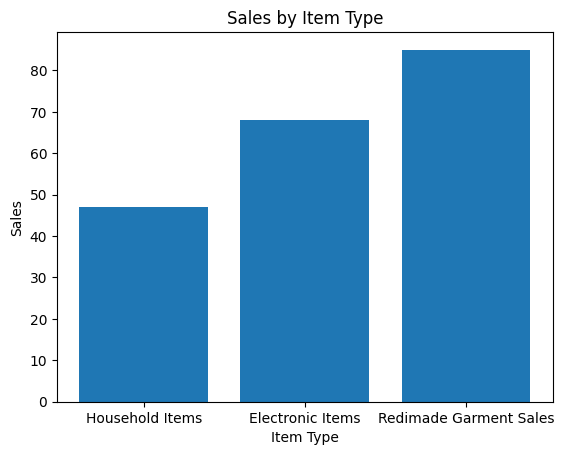


=== Observation ===
Observation: 


=== Final Answer ===
This code will generate a bar chart showing the sales of household items, electronic items, and redimade garment sales. The x-axis represents the item type, and the y-axis represents the sales. The title of the chart is 'Sales by Item Type'. 

Please note that you need to have matplotlib installed in your Python environment to run this code. If it's not installed, you can install it using pip: `pip install matplotlib`.



In [114]:
# Run in streaming mode
result = agent_executor.stream({"input": "Total sales is 200 out of which household items are 23.5% , electronic items are 34% and rest are for redimade grament sales.Generate a bar chart using matplotlib."})
# result = agent_executor.stream({"input": "Search news about AI Agent in 2025."})


for step in result:
    agent_stream_parser.process_agent_steps(step)

## Communicating Agent with previous conversation history

#### To remember past conversations, you can wrap the AgentExecutor with RunnableWithMessageHistory.

#### For more details on RunnableWithMessageHistory, please refer langchain doc

In [116]:
from typing import Dict, Any, Callable


# 1. Define AgentCallbacks class
class AgentCallbacks:
    def __init__(
        self,
        tool_callback: Callable,
        observation_callback: Callable,
        result_callback: Callable,
    ):
        self.tool_callback = tool_callback
        self.observation_callback = observation_callback
        self.result_callback = result_callback


# 2. Define AgentStreamParser class
class AgentStreamParser:
    def __init__(self, callbacks: AgentCallbacks):
        self.callbacks = callbacks

    def process_agent_steps(self, step: Dict[str, Any]) -> None:
        if "actions" in step:
            for action in step["actions"]:
                self.callbacks.tool_callback(
                    {"tool": action.tool, "tool_input": action.tool_input}
                )
        elif "output" in step:
            self.callbacks.result_callback(step["output"])
        else:
            self.callbacks.observation_callback(step)


# 3. Define callback functions
def tool_callback(tool) -> None:
    print("<<<<<<< Tool Called >>>>>>")
    print(f"Tool: {tool.get('tool')}")
    print(f"Input: {tool.get('tool_input')}")
    print("<<<<<<< Tool Called >>>>>>")


def observation_callback(step) -> None:
    print("<<<<<<< Observation >>>>>>")
    observation_data = step["steps"][0].observation
    print(f"Observation: {observation_data}")
    print("<<<<<<< Observation >>>>>>")


def result_callback(result: str) -> None:
    print("<<<<<<< Final Answer >>>>>>")
    print(result)
    print("<<<<<<< Final Answer >>>>>>")


# 4. Example usage
# Wrap callback functions into AgentCallbacks instance
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback,
    observation_callback=observation_callback,
    result_callback=result_callback,
)

# Create AgentStreamParser instance
agent_stream_parser = AgentStreamParser(agent_callbacks)

In [117]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

# create a dictionary to store message history
store = {}

# function to get session history by passing session_ids
def get_session_history(session_id):
    if not store.get(session_id):
        store[session_id] = ChatMessageHistory()
    return store.get(session_id)

# create an agent with chat message history
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history"
)




In [118]:
# request streaming output 
response = agent_with_chat_history.stream(
    {"input":"Hello my name is Durgesh"},
    config={"configurable": {"session_id": "durgeshses1"}},
)
for step in response :
    agent_stream_parser.process_agent_steps(step)

<<<<<<< Final Answer >>>>>>
Hello Durgesh, it's nice to meet you. Is there something I can help you with or would you like to chat?
<<<<<<< Final Answer >>>>>>


In [88]:
response = agent_with_chat_history.stream(
    {"input":"What is my name"},
    config={"configurable": {"session_id": "durgeshses1"}},
)
for step in response :
    agent_stream_parser.process_agent_steps(step)

<<<<<<< Final Answer >>>>>>
Your name is Durgesh.
<<<<<<< Final Answer >>>>>>


In [119]:
response = agent_with_chat_history.stream(
    {"input":"My email address is durgesh@unicodesystems.info. The company name is Unicode Systems Pvt., Ltd"},
    config={"configurable": {"session_id": "durgeshses1"}},
)
for step in response :
    agent_stream_parser.process_agent_steps(step)

<<<<<<< Final Answer >>>>>>
Hello Durgesh from Unicode Systems Pvt., Ltd. It's nice to have your contact information. How can I assist you today? Do you have any specific questions, need help with a problem, or would you like to discuss something related to your company?
<<<<<<< Final Answer >>>>>>


In [122]:
response = agent_with_chat_history.stream(
    {"input": "Search the latest news and write it as the body of the email. "
        "The recipient is `Mr. Kuldeep` and the sender is my personal information."
        "Write in a polite tone, and include appropriate greetings and closings at the beginning and end of the email"}
    ,
    config={"configurable": {"session_id": "durgeshses1"}},
)
for step in response :
    # print(step)
    agent_stream_parser.process_agent_steps(step)

<<<<<<< Tool Called >>>>>>
Tool: search_news
Input: {'query': 'latest news'}
<<<<<<< Tool Called >>>>>>
<<<<<<< Observation >>>>>>
Observation: [{'url': 'https://apnews.com/', 'content': '(AP Photo/Evan Vucci)](https://dims.apnews.com/dims4/default/60660ba/2147483647/strip/true/crop/3776x2515+0+1/resize/599x399!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2F61%2F8f%2Faa758ad2a1ddd9d4f87c3808b237%2F1a05cc8f537e4b1d9ece992550ec30c5)](https://apnews.com/article/trump-biden-security-clearance-revoked-be82cd4f185f01404718fcc69e074fbf) [![Image 17: This image released by A24 shows Adrien Brody, left, and Felicity Jones in a scene from "The Brutalist." (A24 via AP)](https://dims.apnews.com/dims4/default/b9c3529/2147483647/strip/true/crop/3000x2000+0+0/resize/567x378!/quality/90/?url=https%3A%2F%2Fassets.apnews.com%2F2d%2F9f%2F58f2e502e34e50808f3990ee499d%2Feada6dae654f4e479f25df4e1c955c7b)](https://apnews.com/article/where-to-watch-2025-top-movies-nominees-da4415ab55e4eb86ce5bdfafc8d76914

In [121]:
response = agent_with_chat_history.stream(
    {"input": "What is my email. "}
    ,
    config={"configurable": {"session_id": "durgeshses1"}},
)
for step in response :
    print(step)
    agent_stream_parser.process_agent_steps(step)

{'output': 'Your email address is durgesh@unicodesystems.info.', 'messages': [AIMessage(content='Your email address is durgesh@unicodesystems.info.', additional_kwargs={}, response_metadata={})]}
<<<<<<< Final Answer >>>>>>
Your email address is durgesh@unicodesystems.info.
<<<<<<< Final Answer >>>>>>
